# Plant Seedlings Challenge

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import os, sys

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.preprocessing import LabelEncoder

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.cuda.set_device(0)

In [7]:
PATH = "data/"
sz = 224
arch = resnext101_64
bs = 58

In [8]:
!ls {PATH}

sample_submission.csv
test
train


In [131]:
train_directory = f'{PATH}train/'

columns = ['file_name', 'label']
data = []

for blabel in os.listdir(os.fsencode(train_directory)):
    label = blabel.decode('ascii')
    for bfile in os.listdir(os.fsencode(f'{train_directory}{label}')):
        file = bfile.decode('ascii')
        file_ext = '.png'
        if file.endswith(file_ext):
            file_name = file[:-len(file_ext)]
            data.append([file_name, label])
            
            
data = np.array(data)
data

array([['0050f38b3', 'Black-grass'],
       ['0183fdf68', 'Black-grass'],
       ['0260cffa8', 'Black-grass'],
       ...,
       ['fed9406b2', 'Sugar beet'],
       ['fef5e7066', 'Sugar beet'],
       ['ffa401155', 'Sugar beet']], dtype='<U25')

In [132]:
df = pd.DataFrame(data, columns=columns)

In [133]:
df.pivot_table(index="label", aggfunc=len)

file_name
label                               
Black-grass                      263
Charlock                         390
Cleavers                         287
Common Chickweed                 611
Common wheat                     221
Fat Hen                          475
Loose Silky-bent                 654
Maize                            221
Scentless Mayweed                516
Shepherds Purse                  231
Small-flowered Cranesbill        496
Sugar beet                       385

In [134]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [135]:
label_csv = f'{PATH}labels.csv'
df.to_csv(label_csv, index=False)

In [136]:
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [137]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)

In [138]:
arch=resnet34
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy        
    0      2.84242    2.540296   0.106316  
    1      2.617587   2.537011   0.114737        



[array([2.53701]), 0.11473684163470017]

In [139]:
data.val_y

array([ 5,  7,  3,  7,  8,  2,  2,  9, 10, 11,  5,  0,  1,  8,  8,  1,  0,  2, 10,  3,  1, 10,  3,  0, 10,
       10,  8,  9,  4, 10,  8,  1,  7,  2,  6,  2,  3,  1, 10,  5,  3,  5,  5,  2, 10,  7,  5,  5, 10,  2,
        8,  1,  9,  9, 10, 10,  3,  8,  0,  3,  9, 11,  3,  2, 10,  1, 11,  4,  3, 10,  3,  3,  7,  7,  5,
        5,  0,  0,  1, 10,  2,  3,  5,  2,  4,  5,  8,  8,  8,  4,  6,  4,  8,  8,  5,  2,  7,  1,  4,  5,
        8,  7,  7,  8,  3,  4,  5, 10,  3, 11,  9,  2, 10,  2,  0,  3,  0,  5,  5,  2,  5,  4,  7,  3,  8,
        2,  8,  5, 11,  8,  2,  8,  8,  7,  5,  2,  2,  6,  3,  8, 10, 11,  8,  7, 10,  9,  4,  0, 10,  6,
        5,  0,  2,  5,  5,  1, 11,  2,  5,  3,  8,  3,  0,  9,  8,  9,  5, 10,  1,  0,  3,  8,  5,  5,  3,
        3,  8,  8,  2,  6,  7,  8,  3,  0,  2,  8,  8, 10,  4,  4, 10,  0,  0,  8,  8,  1,  0,  1,  5,  5,
       10, 11,  9, 10, 11,  6, 10,  3,  4,  6,  2, 11, 11,  3,  4,  5,  5,  5,  7,  4,  1,  5,  7,  1,  5,
       10,  3, 11,  2,  0,  8,  1, 11

In [140]:
data.classes

['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9']

In [141]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(950, 12)

In [146]:
log_preds[0]

array([-3.17195, -4.16427, -3.96404, -2.14489, -3.59694, -3.51237, -1.92032, -1.34402, -2.90634, -3.67741,
       -1.34825, -6.10878], dtype=float32)

In [195]:
def plotMostCorrectAndIncorrectCategories(cat):
    preds = np.argmax(log_preds, axis=1)
    probs = np.exp(log_preds[:,cat])        

    def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
    def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

    def plots(ims, figsize=(12,6), rows=1, titles=None):
        f = plt.figure(figsize=figsize)
        for i in range(len(ims)):
            sp = f.add_subplot(rows, len(ims)//rows, i+1)
            sp.axis('Off')
            if titles is not None: sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i])

    def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

    def plot_val_with_title(idxs, title):
        imgs = [load_img_id(data.val_ds,x) for x in idxs]
        title_probs = [probs[x] for x in idxs]
        print(title)
        return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

    def most_by_mask(mask, mult):
        idxs = np.where(mask)[0]
        return idxs[np.argsort(mult * probs[idxs])[:4]]

    def most_by_correct(y, is_correct): 
        mult = -1 if (y==1)==is_correct else 1
        return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)
    
    label = label_encoder.inverse_transform([cat])[0]
    plot_val_with_title(most_by_correct(cat, True), f'Most correct {label}')
    plot_val_with_title(most_by_correct(cat, False), f'Most incorrect {label}')

Most correct Black-grass
Not Found.
Most incorrect Black-grass


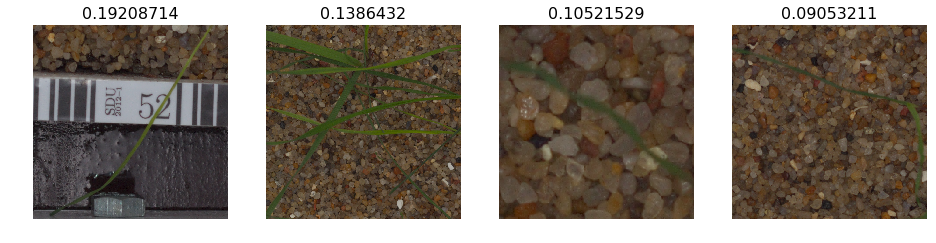

In [197]:
plotMostCorrectAndIncorrectCategories(0)

Most correct Charlock
Most incorrect Charlock


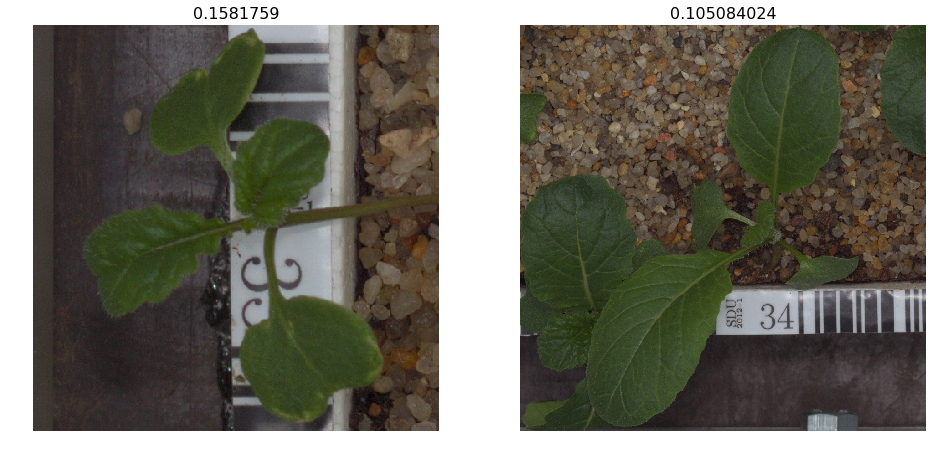

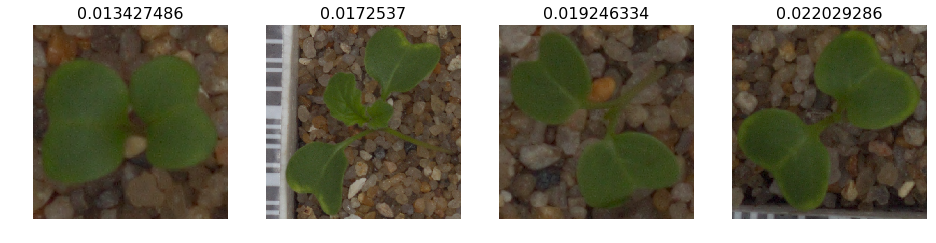

In [198]:
plotMostCorrectAndIncorrectCategories(1)

Most correct Cleavers
Most incorrect Cleavers


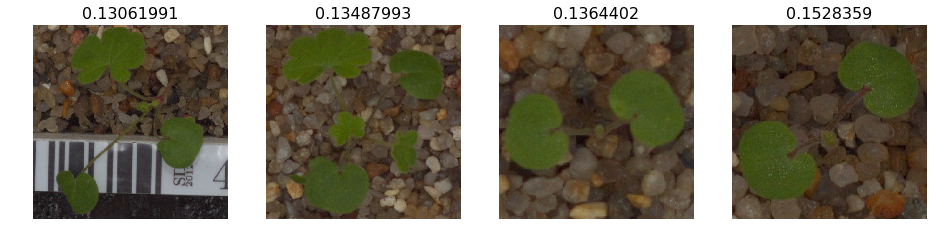

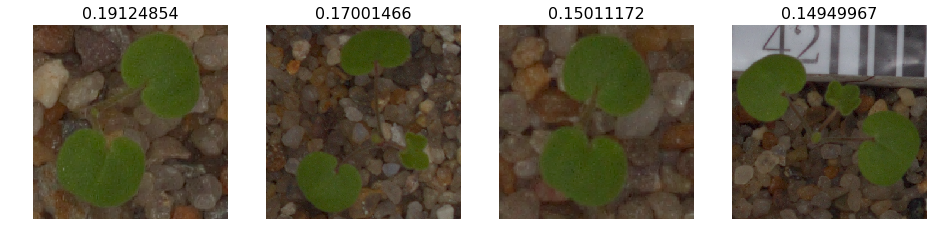

In [199]:
plotMostCorrectAndIncorrectCategories(2)

Most correct Common Chickweed
Most incorrect Common Chickweed


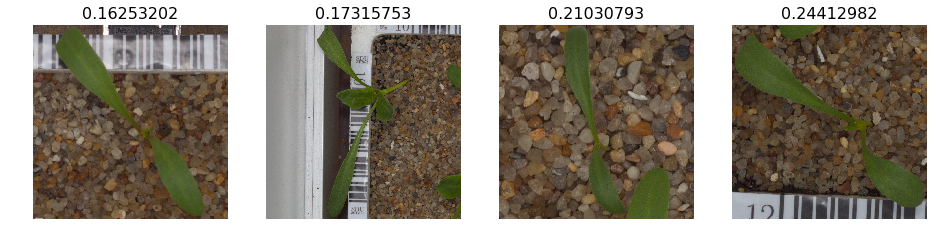

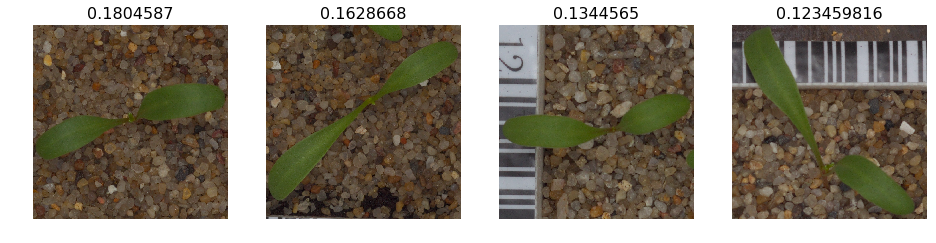

In [200]:
plotMostCorrectAndIncorrectCategories(3)

Most correct Common wheat
Not Found.
Most incorrect Common wheat


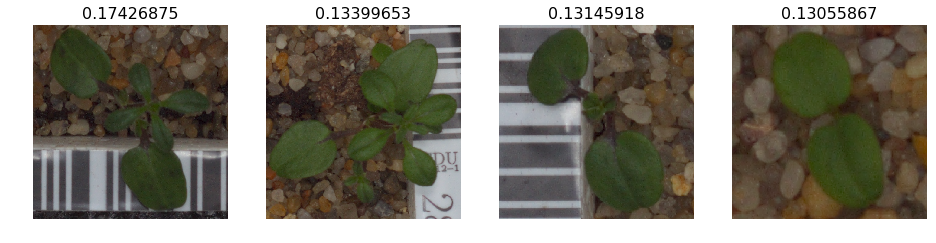

In [201]:
plotMostCorrectAndIncorrectCategories(4)

Most correct Fat Hen
Most incorrect Fat Hen


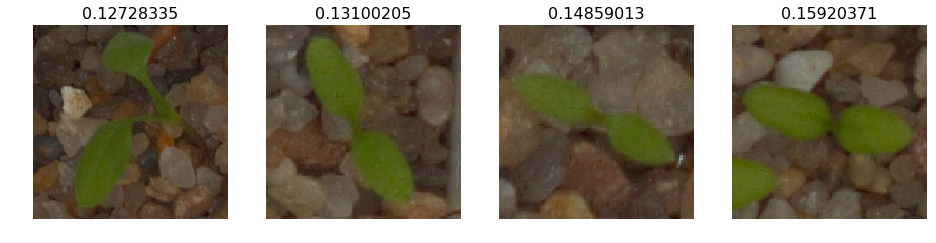

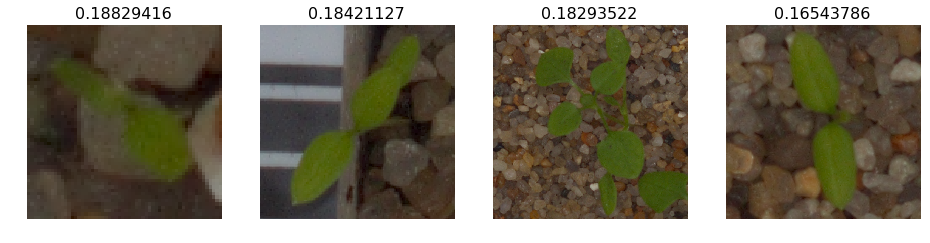

In [202]:
plotMostCorrectAndIncorrectCategories(5)

Most correct Loose Silky-bent
Not Found.
Most incorrect Loose Silky-bent


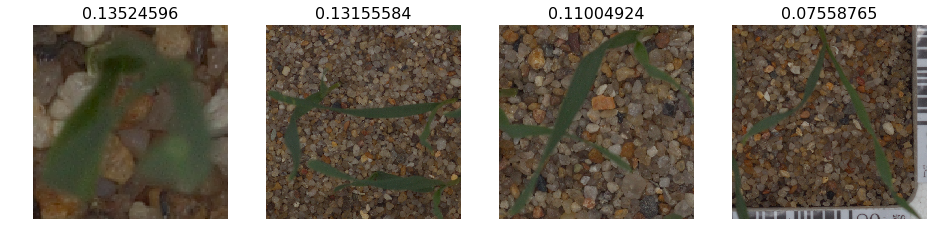

In [203]:
plotMostCorrectAndIncorrectCategories(6)

Most correct Maize
Most incorrect Maize


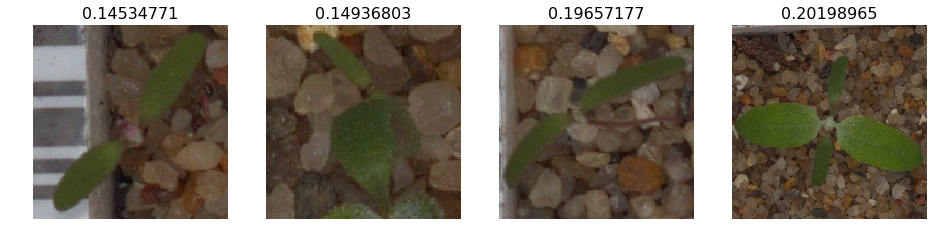

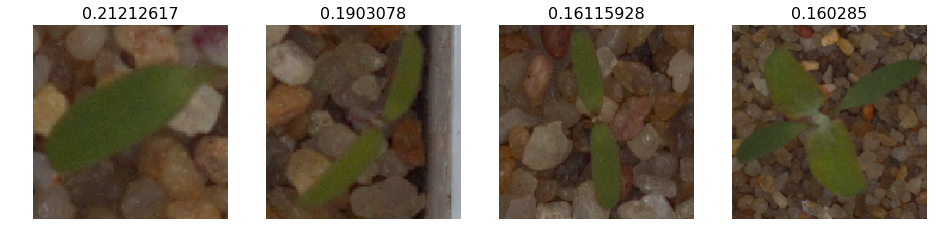

In [204]:
plotMostCorrectAndIncorrectCategories(7)

Most correct Scentless Mayweed
Most incorrect Scentless Mayweed


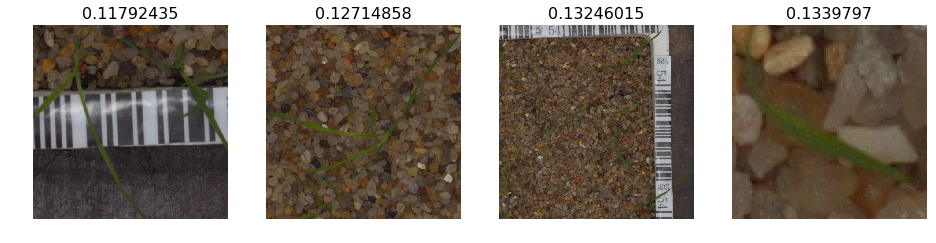

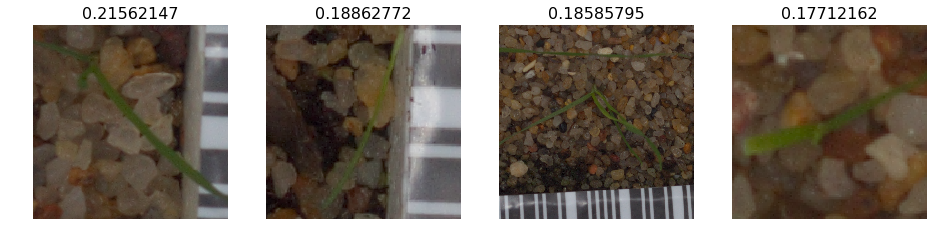

In [205]:
plotMostCorrectAndIncorrectCategories(8)

Most correct Shepherds Purse
Not Found.
Most incorrect Shepherds Purse


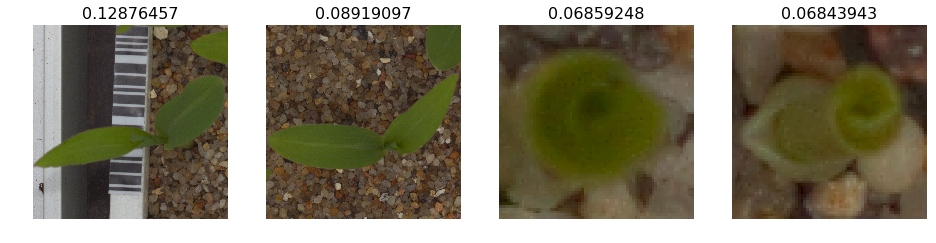

In [206]:
plotMostCorrectAndIncorrectCategories(9)

Most correct Small-flowered Cranesbill
Most incorrect Small-flowered Cranesbill


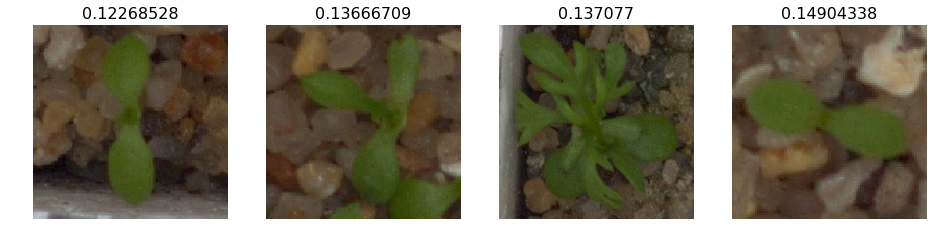

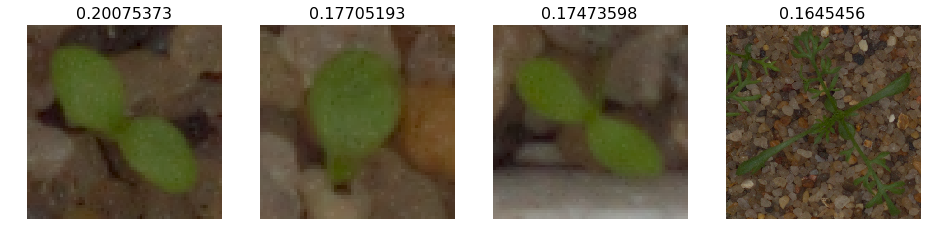

In [207]:
plotMostCorrectAndIncorrectCategories(10)

In [ ]:
plotMostCorrectAndIncorrectCategories(11)